In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
config.update("jax_enable_x64", True)

# Set parameters.

In [10]:
# Parameters.
x_dimension = 3
y_dimension = 3

n_site = x_dimension * y_dimension

U = 1
t = 1.0
t_prime = 0.3
mu = -0.5

# Exact part

## Find eigenvalues for different electron counts.

In [6]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [11]:
n_electrons_eigvals = []

# for n_electrons in range(2 * n_site + 1):
for n_electrons in range(5):

    valid_indices = []
    for bits in product('01', repeat= 2 * x_dimension * y_dimension):
        
        if bits.count('1') == n_electrons:
            binary_str = ''.join(bits)
            valid_indices.append(int(binary_str, 2))

    indices = jnp.array(valid_indices)

    H_reduced = reduced_hubbard_model(U=U, indices=indices)

    H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
    n_electrons_eigvals.append(H_reduced_eigvals)
    print(f"Eigenvalues of {n_electrons} electrons:", jnp.round(H_reduced_eigvals[:5], 3))

Eigenvalues of 0 electrons: [0.]
Eigenvalues of 1 electrons: [-4.7 -4.7  0.1  0.1  0.1]
Eigenvalues of 2 electrons: [-9.297 -4.6   -4.6   -4.6   -4.6  ]
Eigenvalues of 3 electrons: [-9.096 -9.096 -9.096 -9.096 -9.096]
Eigenvalues of 4 electrons: [-8.897 -8.893 -8.893 -8.893 -8.893]


## Find the electron count in the ground state.

In [12]:
n_electrons_ground_eigvals = [subarray[0] for subarray in n_electrons_eigvals]
n_electrons_ground_eigvals = jnp.array(n_electrons_ground_eigvals)
# 找到最小值的索引
ground_state_electron_counts = jnp.argmin(n_electrons_ground_eigvals)
print('ground_state_electron_counts:', ground_state_electron_counts)

ground_state_electron_counts: 2


## Construct the reduced Hamiltonian.

In [13]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):
    
    if ground_state_electron_counts - 1 <= bits.count('1') <= ground_state_electron_counts + 1:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues of {ground_state_electron_counts-1} ~ {ground_state_electron_counts+1} electrons:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 987
Eigenvalues of 1 ~ 3 electrons: [-9.297 -9.096 -9.096 -9.096 -9.096 -9.096 -9.096 -9.096]


# Determinant method

## Construct the Hamiltonian.

In [15]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [16]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-9.4 -9.3 -9.3 -9.3 -9.3 -9.3 -9.3 -9.3]


In [17]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:2])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [1, 8, 8, 2, 16, 56, 16, 128, 56, 8, 28, 56, 8, 64, 224, 28, 224, 56]
Number of degerate Eigenvalues:
 [1, 8]
Eigenvalues of first Hi: 
 [0.11111111]


In [18]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [19]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

# Binary search

# error $ = 10^{-3}$

In [20]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [21]:
U_sweep = jnp.linspace(0, U, 11)

In [22]:
H0_eigvals_updated

Array([-9.4, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3, -9.3], dtype=float64)

In [23]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 3 iterations.
-9.389664165114516
solve: 2
Converged in 3 iterations.
-9.378841846229477
solve: 3
Converged in 3 iterations.
-9.368145465026123
solve: 4
Converged in 3 iterations.
-9.357610213004811
solve: 5
Converged in 3 iterations.
-9.347235284999234
solve: 6
Converged in 3 iterations.
-9.337017704437264
solve: 7
Converged in 3 iterations.
-9.32695443560296
solve: 8
Converged in 3 iterations.
-9.31704251398903
solve: 9
Converged in 3 iterations.
-9.30727905277363
solve: 10
Converged in 3 iterations.
-9.29766124147833


In [24]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

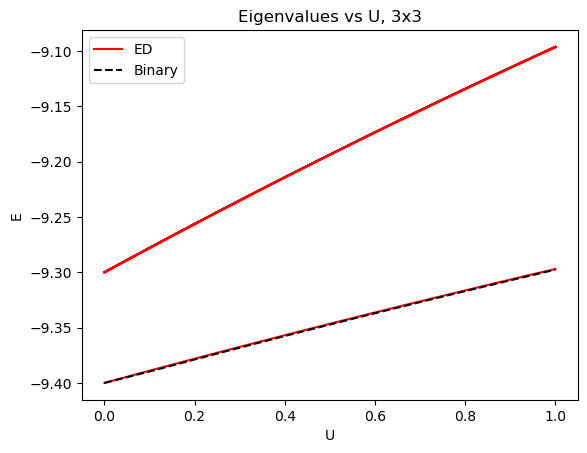

In [25]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [26]:
def _Psi_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N
    
    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    Heff =  jnp.real(Hij + Rij)
    Heff_eigvals, Heff_eigvecs = jnp.linalg.eigh(Heff)

    
    
    Proj_Psi = degeneracy_eigvecs @ Heff_eigvecs
    Psi = Proj_Psi + Q @ M_inv @ Q @ H @ Proj_Psi

    Psi_norm = jnp.zeros_like(Psi)
    for i in range(degeneracy_dim):
        Psi_norm = Psi_norm.at[:,i].set(Psi[:,i]/jnp.linalg.norm(Psi[:,i]))

    return Psi_norm

In [27]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

## Green's function

## Annihilation and creation operator


In [28]:
X = sp.csr_matrix([[0, 1], [1, 0]], dtype=complex)
Y = sp.csr_matrix([[0, -1j], [1j, 0]], dtype=complex)
Z = sp.csr_matrix([[1, 0], [0, -1]], dtype=complex)
I = sp.eye(2, dtype=complex, format='csr')

def reduced_annihilation_operator(n_site, index, indices):
    N = 2 * n_site

    Z_tensor = sp.eye(1, dtype=complex, format='csr')
    for _ in range(index - 1):
        Z_tensor = sp.kron(Z_tensor, Z, format='csr')

    middle_part = 0.5 * (X + 1j * Y)
    
    I_tensor = sp.eye(1, dtype=complex, format='csr')
    for _ in range(N - index):
        I_tensor = sp.kron(I_tensor, I, format='csr')
    
    a_i = sp.kron(sp.kron(Z_tensor, middle_part, format='csr'), I_tensor, format='csr')
    
    return a_i[jnp.ix_(indices, indices)].toarray()

## Retarded Green's function
### $$ G^{R}_{ij}(\omega) = \bra{\Psi_0}\hat{a}_i(\omega-(\hat{H}-E_0)+i\eta)^{-1}\hat{a}_j^\dagger\ket{\Psi_0} +\bra{\Psi_0}\hat{a}_j^\dagger(\omega+(\hat{H}-E_0)+i\eta)^{-1}\hat{a}_i\ket{\Psi_0} $$

In [29]:
def reduced_retarded_Greens_func_ij(H, z, ground_eigval, ground_eigvec, index_i, index_j, n_site, indices):

    dim = len(indices)
    
    a_i = reduced_annihilation_operator(n_site, index_i, indices)
    a_j = reduced_annihilation_operator(n_site, index_j, indices)

    eta = 1E-5

    plus_denominator = (z + ground_eigval + 1j * eta) * jnp.eye(dim) - H
    minus_denominator = (z - ground_eigval + 1j * eta) * jnp.eye(dim) + H

    plus_denominator_inv = jnp.linalg.inv(plus_denominator)
    minus_denominator_inv = jnp.linalg.inv(minus_denominator)

    Gij = ground_eigvec @ a_i @ plus_denominator_inv @ a_j.T @ ground_eigvec \
            + ground_eigvec @ a_j.T @ minus_denominator_inv @ a_i @ ground_eigvec
    
    return Gij

In [30]:
singularity_energy = jnp.array([])
Exact_ground_state = H_reduced_eigvals[0]

for En in n_electrons_eigvals[ground_state_electron_counts-1]:
    singularity_energy = jnp.append(singularity_energy, Exact_ground_state-En)
for En in n_electrons_eigvals[ground_state_electron_counts+1]:
    singularity_energy = jnp.append(singularity_energy, En-Exact_ground_state)
singularity_energy = singularity_energy.sort()
print(singularity_energy)

[-11.4970475  -11.4970475  -11.4970475  -11.4970475  -11.4970475
 -11.4970475  -11.4970475  -11.4970475   -9.3970475   -9.3970475
  -9.3970475   -9.3970475   -9.3970475   -9.3970475   -9.3970475
  -9.3970475   -4.5970475   -4.5970475    0.2006765    0.2006765
   0.2006765    0.2006765    0.2006765    0.2006765    0.2006765
   0.2006765    2.29336126   2.29336126   2.29336126   2.29336126
   2.29336126   2.29336126   2.29336126   2.29336126   4.7970475
   4.7970475    4.7970475    4.7970475    4.7970475    4.7970475
   4.7970475    4.7970475    4.7970475    4.7970475    4.7970475
   4.7970475    4.7970475    4.7970475    4.7970475    4.7970475
   4.7970475    4.7970475    4.7970475    4.7970475    4.7970475
   4.7970475    4.7970475    4.7970475    4.89598973   4.89598973
   4.98503622   4.98503622   4.98503622   4.98503622   4.98503622
   4.98503622   4.98503622   4.98503622   5.07920286   5.07920286
   5.07920286   5.07920286   5.07920286   5.07920286   5.07920286
   5.07920286   5.09

In [31]:
E_range = jnp.linspace(singularity_energy[0] - 0.5, singularity_energy[-1] + 0.5, 400)

In [32]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

In [33]:
Im_tr_G_values = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = H_reduced_eigvals[0], ground_eigvec = H_reduced_eigvecs[:, 0]
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values = Im_tr_G_values.at[i].set(jnp.imag(tr_G_value))

# Fig

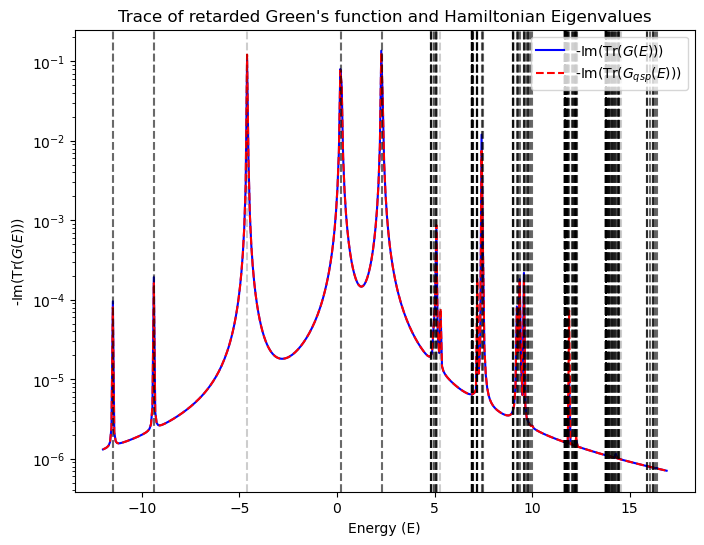

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

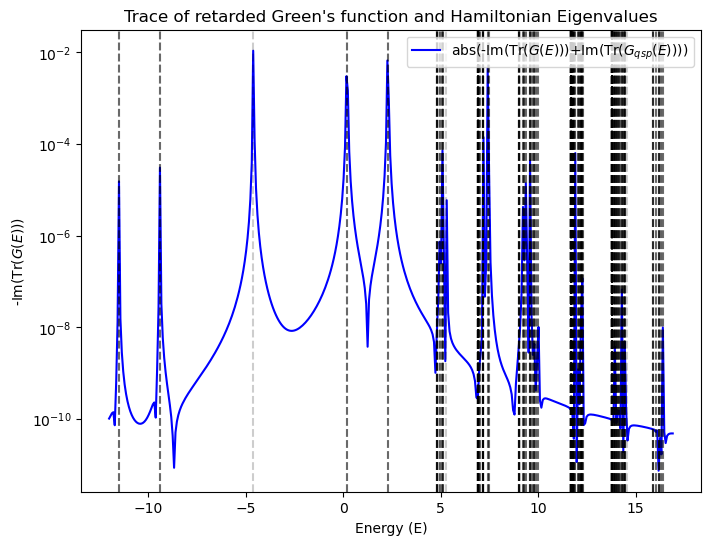

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-6}$

In [36]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [37]:
U_sweep = jnp.linspace(0, U, 11)

In [38]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 13 iterations.
-9.388976193586009
solve: 2
Converged in 13 iterations.
-9.378122622422712
solve: 3
Converged in 13 iterations.
-9.367436511763788
solve: 4


Converged in 13 iterations.
-9.356914481446701
solve: 5
Converged in 13 iterations.
-9.34655322762042
solve: 6
Converged in 13 iterations.
-9.33634952116562
solve: 7
Converged in 13 iterations.
-9.326300206088279
solve: 8
Converged in 13 iterations.
-9.316402197930216
solve: 9
Converged in 13 iterations.
-9.306652482198134
solve: 10
Converged in 13 iterations.
-9.297048112812774


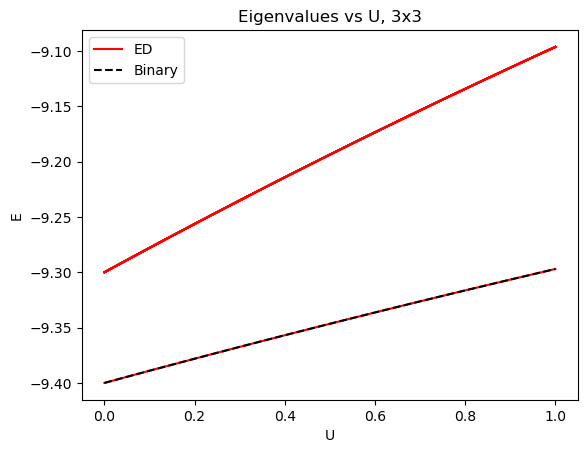

In [39]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [40]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [41]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

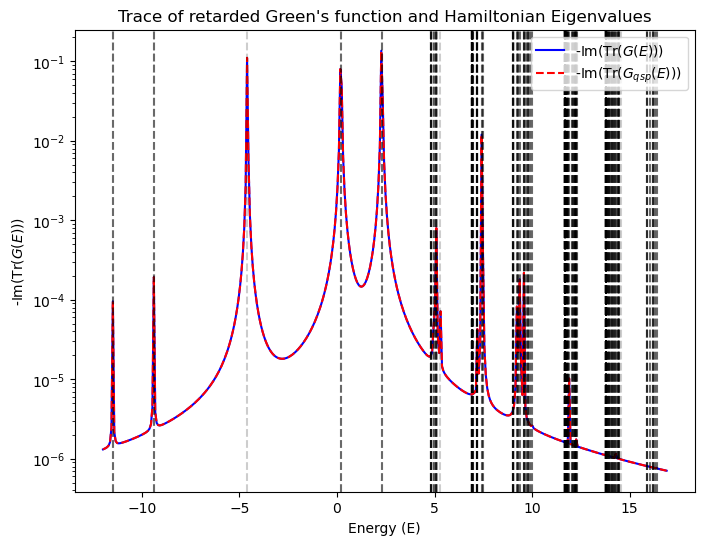

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

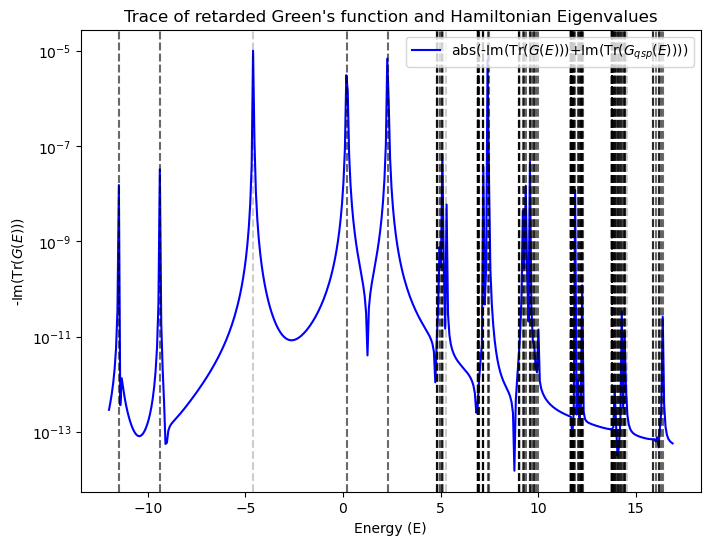

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-8}$

In [44]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [45]:
U_sweep = jnp.linspace(0, U, 11)

In [46]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 20 iterations.
-9.388975526033562
solve: 2
Converged in 20 iterations.
-9.378121965212253
solve: 3
Converged in 20 iterations.
-9.367435864422479
solve: 4


Converged in 20 iterations.
-9.356913843216411
solve: 5
Converged in 19 iterations.
-9.346552602450789
solve: 6
Converged in 19 iterations.
-9.336348902900294
solve: 7
Converged in 19 iterations.
-9.326299593446453
solve: 8
Converged in 19 iterations.
-9.316401589556563
solve: 9
Converged in 19 iterations.
-9.306651876726281
solve: 10
Converged in 19 iterations.
-9.297047508935442


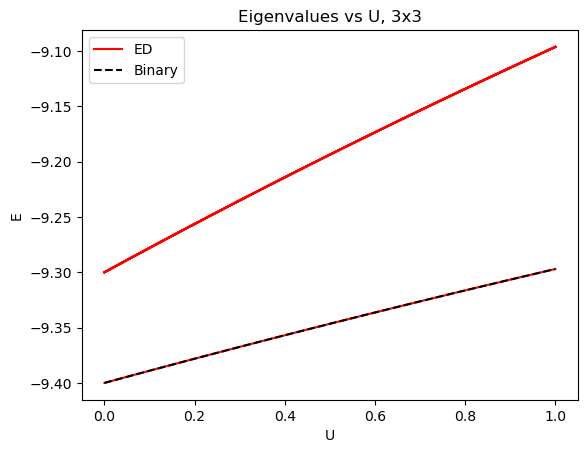

In [47]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [48]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [49]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

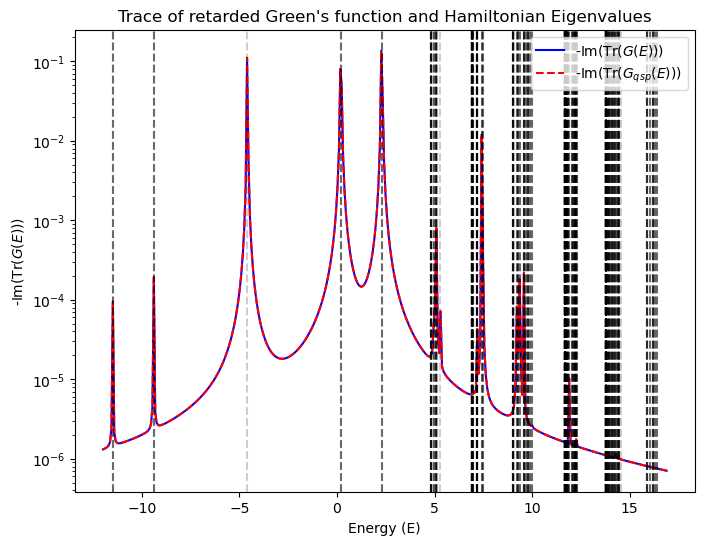

In [50]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

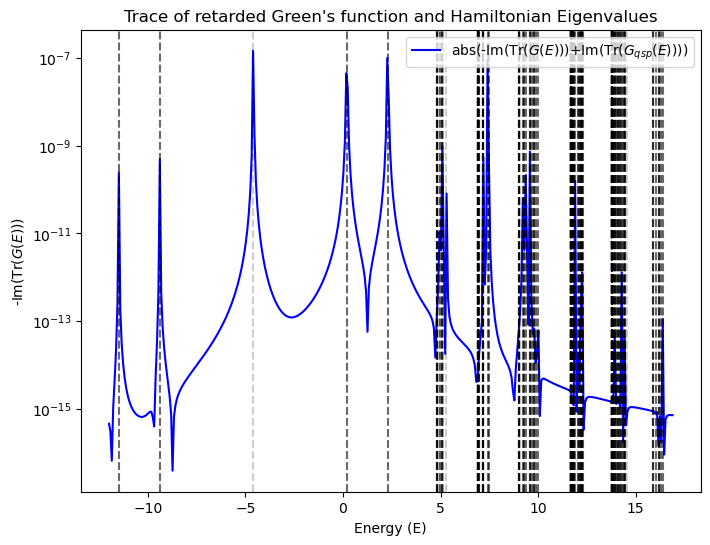

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# Wegstien's method

# error $ = 10^{-3}$

In [52]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [53]:
U_sweep = jnp.linspace(0, U, 11)

In [54]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-9.388975132432712
solve: 2
Converged in 1 iterations.
-9.37812045326949
solve: 3
Converged in 1 iterations.
-9.367432581376555
solve: 4
Converged in 1 iterations.
-9.356908223109972
solve: 5
Converged in 1 iterations.
-9.346544170329427
solve: 6
Converged in 1 iterations.
-9.33633729853808
solve: 7
Converged in 1 iterations.
-9.326284565098353
solve: 8
Converged in 1 iterations.
-9.31638300747025
solve: 9
Converged in 1 iterations.
-9.306629741418107
solve: 10
Converged in 1 iterations.
-9.297021959133293


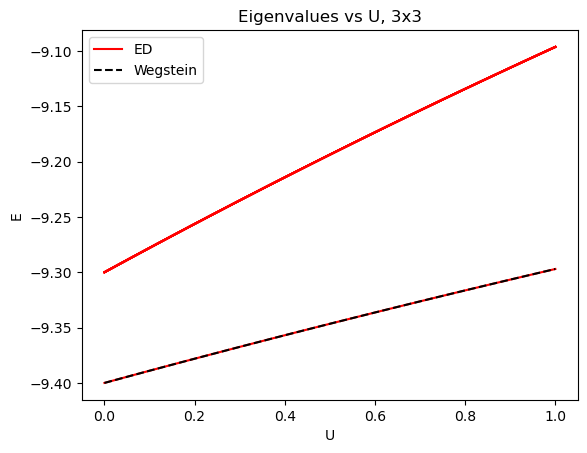

In [55]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [56]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [57]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

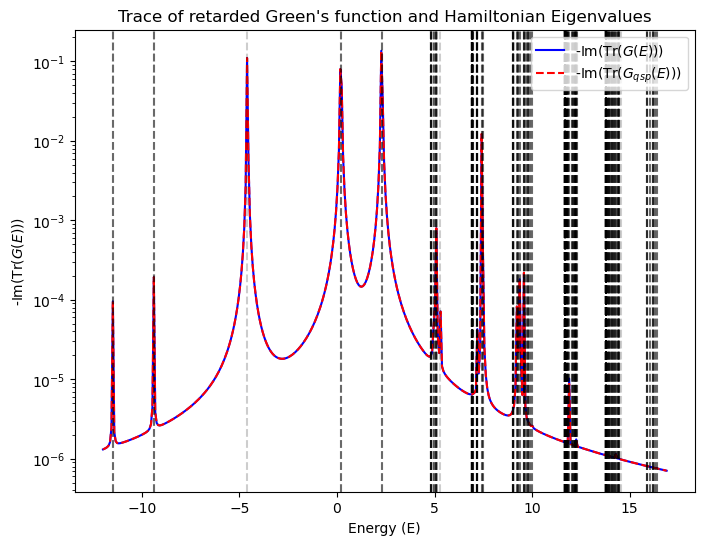

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

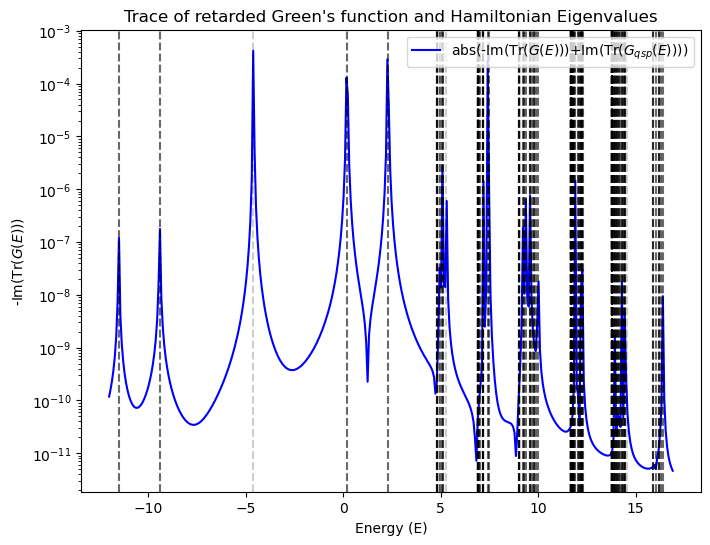

In [59]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-6}$

In [60]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [61]:
U_sweep = jnp.linspace(0, U, 11)

In [62]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 1 iterations.
-9.388975520779077
solve: 2
Converged in 1 iterations.
-9.378121960219888
solve: 3
Converged in 1 iterations.
-9.367435860122727
solve: 4
Converged in 2 iterations.
-9.356913840276734
solve: 5
Converged in 2 iterations.
-9.346552596825346
solve: 6
Converged in 2 iterations.
-9.336348900641458
solve: 7
Converged in 2 iterations.
-9.32629959572723
solve: 8
Converged in 2 iterations.
-9.316401597623852
solve: 9
Converged in 2 iterations.
-9.306651891827158
solve: 10
Converged in 2 iterations.
-9.297047532258746


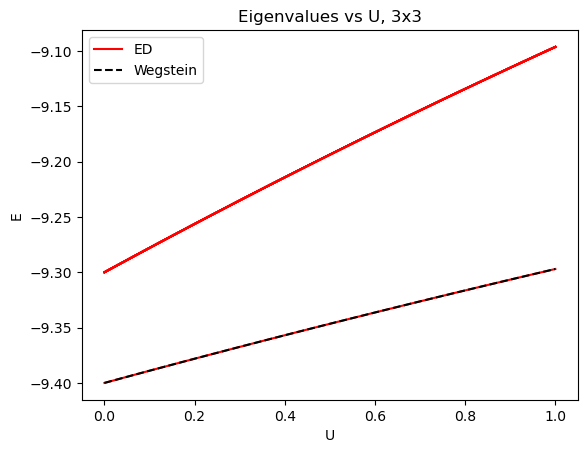

In [63]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [64]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [65]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

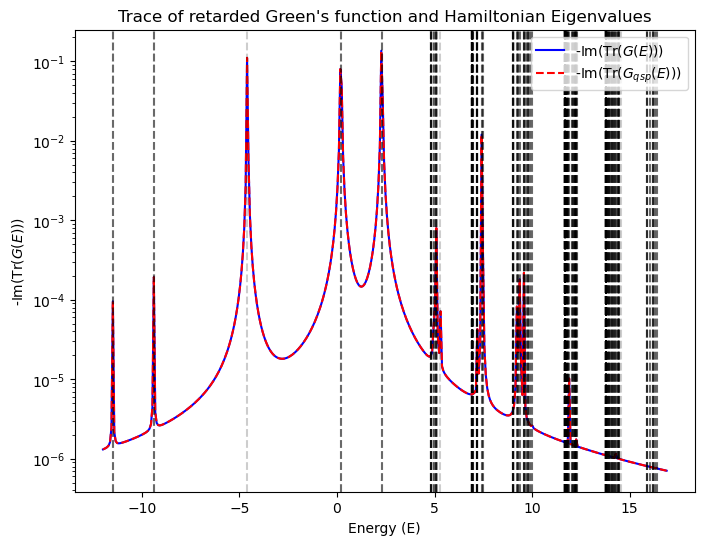

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

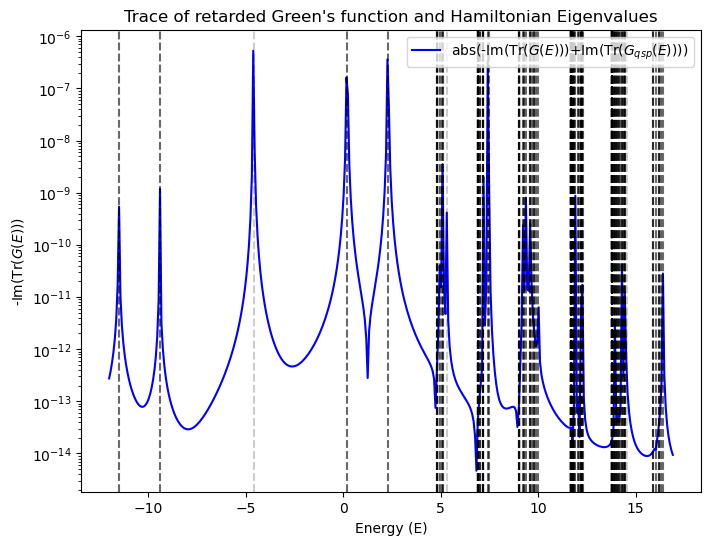

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

# error $ = 10^{-8}$

In [68]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [69]:
U_sweep = jnp.linspace(0, U, 11)

In [70]:
solved_eigvals = [[H0_eigvals_updated[0].item()]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(1):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-9.388975520777572
solve: 2
Converged in 5 iterations.
-9.378121960039289
solve: 3
Converged in 2 iterations.
-9.367435859334975
solve: 4
Converged in 2 iterations.
-9.356913838212646
solve: 5
Converged in 2 iterations.
-9.34655259260666
solve: 6
Converged in 2 iterations.
-9.336348893220087
solve: 7
Converged in 2 iterations.
-9.326299583929316
solve: 8
Converged in 2 iterations.
-9.316401580202362
solve: 9
Converged in 2 iterations.
-9.306651867532427
solve: 10
Converged in 2 iterations.
-9.297047499902524


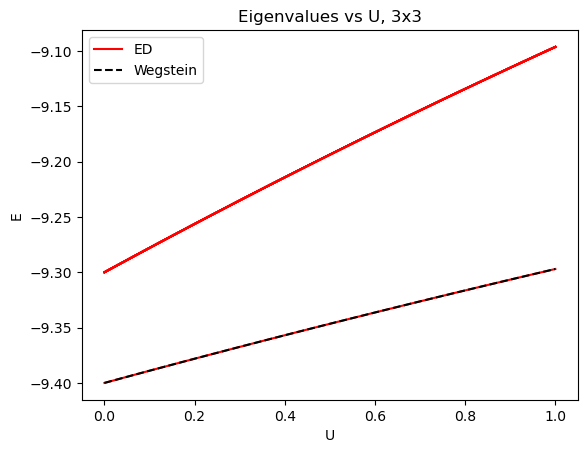

In [71]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')

plt.plot(U_sweep, solved_eigvals[0], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

## Reproduce Psi

In [72]:
ground_state_eigval_qsp = solved_eigvals[0 ,-1]
ground_state_eigvec_qsp = _Psi_qsp(H=H_reduced, E=solved_eigvals[0 ,-1], init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx,
                                    dim=reduced_dim, poly=poly, kappa=kappa)[:, 0].T

In [73]:
Im_tr_G_values_qsp = jnp.zeros_like(E_range)
for i in range(len(E_range)):
    tr_G_value = 0
    for index in range(1, 2 * n_site + 1):
        tr_G_value += reduced_retarded_Greens_func_ij(H=H_reduced, z=E_range[i], ground_eigval = ground_state_eigval_qsp, ground_eigvec = ground_state_eigvec_qsp
                                    , index_i = index, index_j = index, n_site = n_site, indices=reduced_H_indices)
    Im_tr_G_values_qsp = Im_tr_G_values_qsp.at[i].set(jnp.imag(tr_G_value))

# Fig

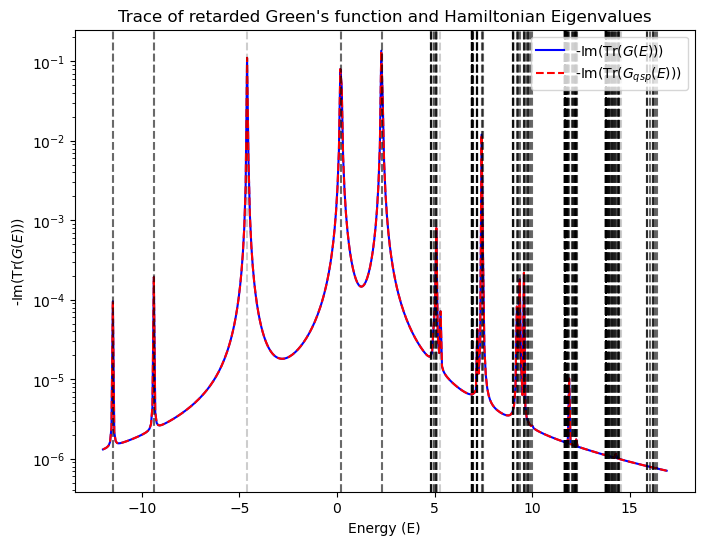

In [74]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, -Im_tr_G_values_qsp, label=r'-Im(Tr$(G_{qsp}(E)))$', color='red', linestyle='--')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()

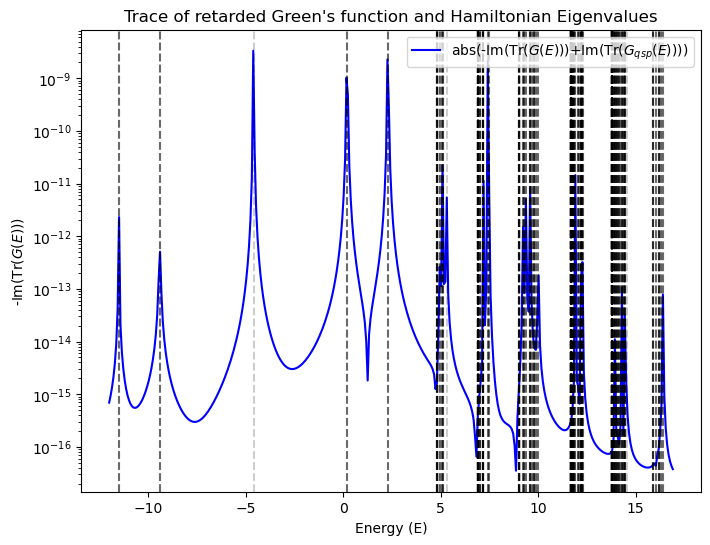

In [75]:
fig, ax = plt.subplots(figsize=(8, 6))

# ax.plot(E_range + H_eigvals[0], -Im_tr_G_values, label=r'-Im(Tr$(G(E)))$', color='blue')
ax.plot(E_range, jnp.abs(-Im_tr_G_values+Im_tr_G_values_qsp), label=r'abs(-Im(Tr($G(E)$))+Im(Tr($G_{qsp}(E)$)))', color='blue')

# for eig in H_reduced_eigvals:
#     ax.axvline(eig, color='red', linestyle='--', alpha=0.7)
for energy in singularity_energy:
    if E_range[0] <= energy <= E_range[-1]:
        ax.axvline(energy, color='black', linestyle='--', alpha=0.1)

ax.set_xlabel('Energy (E)')
ax.set_ylabel(r'-Im(Tr$(G(E)))$')
ax.set_title('Trace of retarded Green\'s function and Hamiltonian Eigenvalues')
ax.legend(loc='upper right')

plt.yscale('log')
plt.show()